# Market Basket Analysis using Apache Spark

In this notebook, we will perform a Market Basket Analysis using the Instacart dataset.
The dataset contains over 3 million grocery orders from more than 200,000 users.
We will use Apache Spark and its MLlib library to perform frequent pattern mining and association rule mining.

<div style="text-align: center;">
    <img src="images/basket-equation.png" alt="Support, Confidence, and Lift metrics" width="882" height="446">
</div>

## Understanding Support, Confidence, and Lift

In Market Basket Analysis, we use three main metrics to evaluate association rules: Support, Confidence, and Lift.

- **Support** 

This measures how frequently the itemset appears in the dataset. It is calculated as the proportion of transactions that contain the itemset.

$\text{Support}(X \Rightarrow Y) = \frac{\text{freq}(X, Y)}{N}$

Where $\text{freq}(X, Y)$ is the number of transactions containing both $X$ and $Y$, and $N$ is the total number of transactions.

- **Confidence**

This measures how often items in $Y$ appear in transactions that contain $X$.
It is calculated as the proportion of transactions containing $X$ that also contain $Y$.

$\text{Confidence}(X \Rightarrow Y) = \frac{\text{freq}(X, Y)}{\text{freq}(X)}$

Where $\text{freq}(X)$ is the number of transactions containing $X$.

- **Lift**

This measures the strength of an association rule over the random co-occurrence of $X$ and $Y$, providing an indicator of the importance of the rule.

$\text{Lift}(X \Rightarrow Y) = \frac{\text{Support}(X \Rightarrow Y)}{\text{Supp}(X) \times \text{Supp}(Y)}$
  
Where $\text{Supp}(X)$ and $\text{Supp}(Y)$ are the individual supports of $X$ and $Y$.

## Importing Libraries

First, we need to import the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, expr
from pyspark.ml.fpm import FPGrowth
from wordcloud import WordCloud

## Initializing Spark Session

We will now initialize a Spark session with the necessary configurations.

In [2]:
spark = (SparkSession.builder
         .appName("basket-analysis")
         .enableHiveSupport()
         .config("spark.driver.memory", "3g")
         .config("spark.executor.memory", "3g")
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/18 21:34:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading the Dataset

Next, we will load the Instacart dataset into Spark DataFrames.
This dataset includes several CSV files, each containing different aspects of the order data.

The dataset can be found on [Kaggle](https://www.kaggle.com/c/instacart-market-basket-analysis/data).

Due to GitHub's file size limits, the dataset is not included directly in the repository.
Please download the dataset from Kaggle, extract the files, and place them in the `data` folder according to the paths specified in the Spark read operations.

In [3]:
INSTACART_DATA = "../data/instacart"

In [4]:
aisles = spark.read.csv(f"{INSTACART_DATA}/aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv(f"{INSTACART_DATA}/departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv(f"{INSTACART_DATA}/order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv(f"{INSTACART_DATA}/order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv(f"{INSTACART_DATA}/orders.csv", header=True, inferSchema=True)
products = spark.read.csv(f"{INSTACART_DATA}/products.csv", header=True, inferSchema=True)

## Creating Temporary Views

We will create temporary views for each of the DataFrames to enable SQL querying.

In [5]:
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

## Exploratory Data Analysis

### Viewing the First Few Rows of Each Table

Let's take a look at the first few rows of each of the imported files to understand their structure and contents.


In [6]:
orders.show(n=5)

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  NULL|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows



In [7]:
products.show(n=5)

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         1|Chocolate Sandwic...|      61|           19|
|         2|    All-Seasons Salt|     104|           13|
|         3|Robust Golden Uns...|      94|            7|
|         4|Smart Ones Classi...|      38|            1|
|         5|Green Chile Anyti...|       5|           13|
+----------+--------------------+--------+-------------+
only showing top 5 rows



In [8]:
aisles.show(n=5)

+--------+--------------------+
|aisle_id|               aisle|
+--------+--------------------+
|       1|prepared soups sa...|
|       2|   specialty cheeses|
|       3| energy granola bars|
|       4|       instant foods|
|       5|marinades meat pr...|
+--------+--------------------+
only showing top 5 rows



In [9]:
departments.show(n=5)

+-------------+----------+
|department_id|department|
+-------------+----------+
|            1|    frozen|
|            2|     other|
|            3|    bakery|
|            4|   produce|
|            5|   alcohol|
+-------------+----------+
only showing top 5 rows



In [10]:
order_products_train.show(n=5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows



In [11]:
order_products_prior.show(n=5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
|       2|      9327|                3|        0|
|       2|     45918|                4|        1|
|       2|     30035|                5|        0|
+--------+----------+-----------------+---------+
only showing top 5 rows



### Orders by Hour of the Day

We will now analyze the distribution of orders by the hour of the day.

In [12]:
query = """
SELECT COUNT(order_id) AS total_orders, order_hour_of_day AS hour 
FROM orders 
GROUP BY order_hour_of_day 
ORDER BY order_hour_of_day
"""
orders_by_hour = spark.sql(query)
orders_by_hour.show(10)

+------------+----+
|total_orders|hour|
+------------+----+
|       22758|   0|
|       12398|   1|
|        7539|   2|
|        5474|   3|
|        5527|   4|
|        9569|   5|
|       30529|   6|
|       91868|   7|
|      178201|   8|
|      257812|   9|
+------------+----+
only showing top 10 rows



### Visualizing Orders by Hour

Let's visualize the number of orders placed at each hour of the day using a line plot.

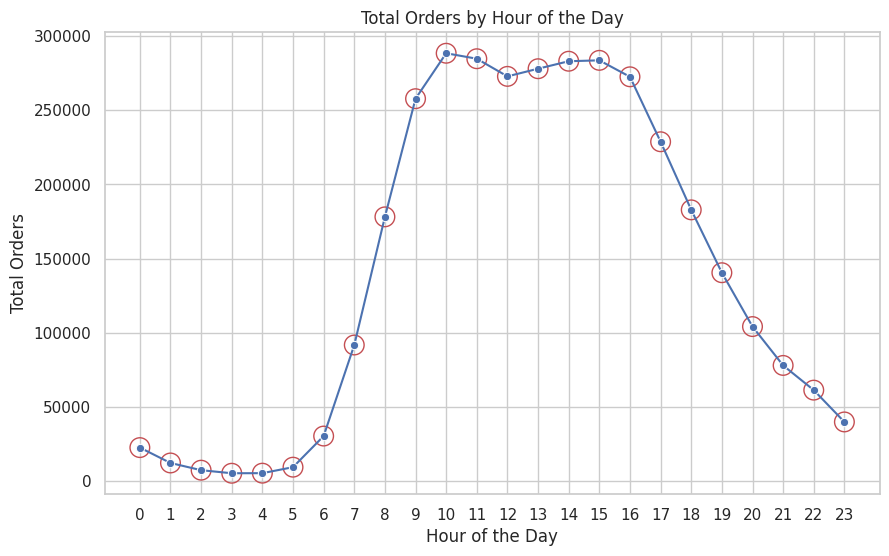

In [13]:
orders_by_hour_plot = orders_by_hour.toPandas()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='total_orders', data=orders_by_hour_plot, marker='o', markersize=6)

for i in range(orders_by_hour_plot.shape[0]):
    plt.scatter(orders_by_hour_plot['hour'][i], orders_by_hour_plot['total_orders'][i], s=200, facecolors='none', edgecolors='r')

plt.title('Total Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Orders')
plt.xticks(range(24))
plt.show()

### Orders by Days Since Prior Order

Next, we will analyze how often customers place orders by looking at the days since their prior order.

In [14]:
query = """
SELECT days_since_prior_order, COUNT(order_id) AS total_orders
FROM orders 
GROUP BY days_since_prior_order 
ORDER BY days_since_prior_order
"""
days_since_prior_order = spark.sql(query)
days_since_prior_order.show(10)

+----------------------+------------+
|days_since_prior_order|total_orders|
+----------------------+------------+
|                  NULL|      206209|
|                   0.0|       67755|
|                   1.0|      145247|
|                   2.0|      193206|
|                   3.0|      217005|
|                   4.0|      221696|
|                   5.0|      214503|
|                   6.0|      240013|
|                   7.0|      320608|
|                   8.0|      181717|
+----------------------+------------+
only showing top 10 rows



### Visualizing Orders by Days Since Prior Order

We will visualize the distribution of orders based on the days since the prior order using a bar plot.

24/06/18 21:34:15 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


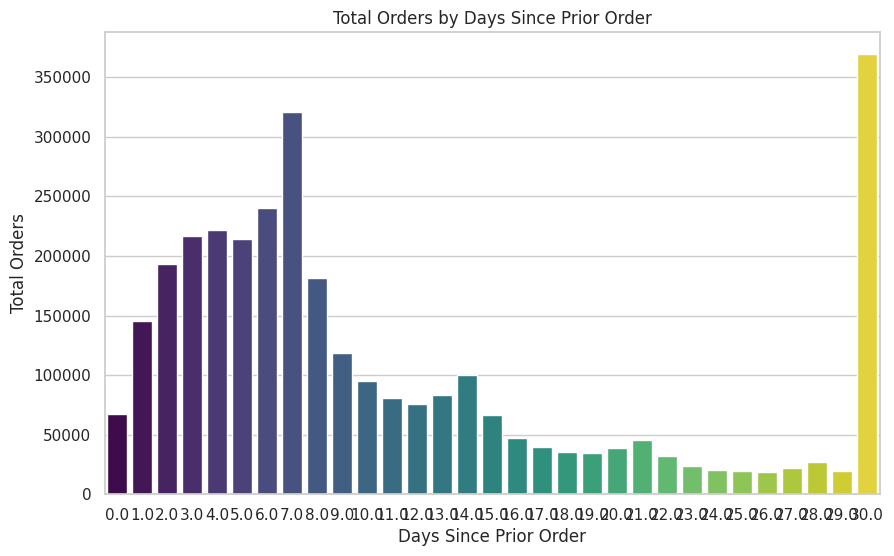

In [15]:
days_since_prior_order_plot = days_since_prior_order.toPandas()


sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='days_since_prior_order', y='total_orders', data=days_since_prior_order_plot, 
            palette='viridis', hue='days_since_prior_order', dodge=False, legend=False)

plt.title('Total Orders by Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Total Orders')
plt.show()

### Orders by Day of the Week

Now, let's analyze on which day of the week customers make the most purchases.

In [16]:
query = """
SELECT COUNT(order_id) AS total_orders, 
  (CASE 
     WHEN order_dow = '0' THEN 'Sunday'
     WHEN order_dow = '1' THEN 'Monday'
     WHEN order_dow = '2' THEN 'Tuesday'
     WHEN order_dow = '3' THEN 'Wednesday'
     WHEN order_dow = '4' THEN 'Thursday'
     WHEN order_dow = '5' THEN 'Friday'
     WHEN order_dow = '6' THEN 'Saturday'              
   end) as day_of_week 
  FROM orders  
 GROUP BY order_dow 
 ORDER BY total_orders desc
"""
order_by_weekday = spark.sql(query)
order_by_weekday.show()

+------------+-----------+
|total_orders|day_of_week|
+------------+-----------+
|      600905|     Sunday|
|      587478|     Monday|
|      467260|    Tuesday|
|      453368|     Friday|
|      448761|   Saturday|
|      436972|  Wednesday|
|      426339|   Thursday|
+------------+-----------+



### Visualizing Orders by Day of the Week

We will visualize the number of orders placed on each day of the week using a bar plot.

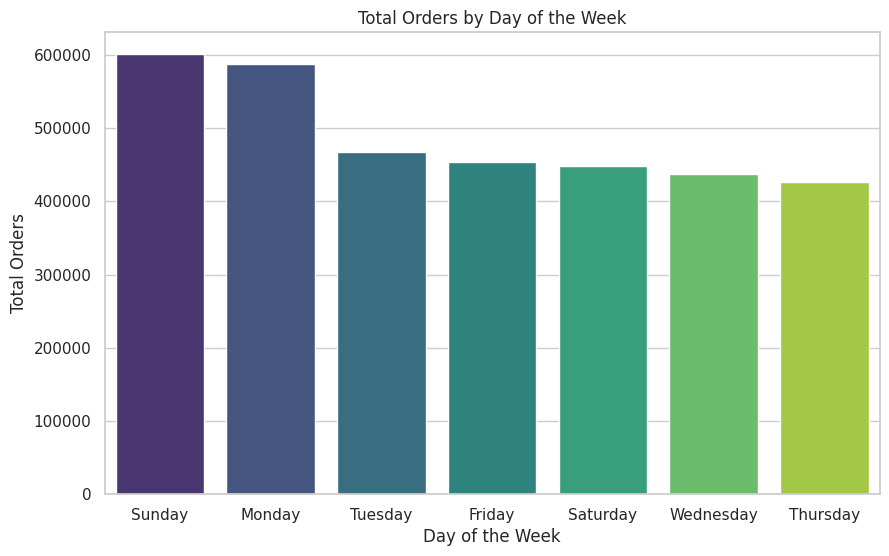

In [17]:
order_by_weekday_plot = order_by_weekday.toPandas()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='total_orders', hue='day_of_week', data=order_by_weekday_plot,
            palette='viridis', dodge=False, legend=False)

plt.title('Total Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Orders')
plt.show()

### Creating a Master Table

Let's create a master table by merging the product, department, order_products_train, and order_products_prior datasets.
This will help us in further analysis.

In [18]:
spark.sql("DROP TABLE IF EXISTS order_items_temp")

query = """
CREATE TABLE order_items_temp AS
(
    SELECT order_products.*, products.product_name, products.aisle_id, products.department_id, departments.department
    FROM
    (
        SELECT * FROM order_products_train 
        UNION
        SELECT * FROM order_products_prior
    ) AS order_products
    INNER JOIN products
    ON order_products.product_id = products.product_id
    INNER JOIN departments
    ON products.department_id = departments.department_id
)
"""
spark.sql(query)

24/06/18 21:34:17 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/06/18 21:34:17 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/06/18 21:34:18 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/06/18 21:34:18 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore rodrigo@192.168.0.90
24/06/18 21:34:18 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/06/18 21:34:19 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
24/06/18 21:34:19 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance o

DataFrame[]

### Number of Items per Order

Now, let's find out how many items customers typically purchase in a single order.

In [19]:
query = """
SELECT order_id, COUNT(product_id) AS total_items
FROM order_items_temp 
GROUP BY order_id
"""
items_by_order = spark.sql(query)
items_by_order.show(10)

+--------+-----------+
|order_id|total_items|
+--------+-----------+
|  154034|         12|
|  348799|          6|
|  417296|          6|
|  528665|         10|
|  572106|         11|
|  401778|         15|
|  522797|         24|
|  251316|         20|
|  256425|          6|
|  534059|         14|
+--------+-----------+
only showing top 10 rows



In [20]:
query = """
SELECT total_items, COUNT(order_id) AS num_orders
FROM
(
    SELECT order_id, COUNT(product_id) AS total_items
    FROM order_items_temp 
    GROUP BY order_id
) AS items_by_order
GROUP BY total_items
ORDER BY total_items
"""
items_by_order_aggregated = spark.sql(query)
items_by_order_aggregated.show(10)

+-----------+----------+
|total_items|num_orders|
+-----------+----------+
|          1|    163593|
|          2|    194361|
|          3|    215060|
|          4|    230300|
|          5|    237224|
|          6|    236383|
|          7|    228548|
|          8|    211357|
|          9|    191563|
|         10|    172103|
+-----------+----------+
only showing top 10 rows



### Visualizing Number of Items per Order

We will visualize the distribution of the number of items per order using a bar plot.

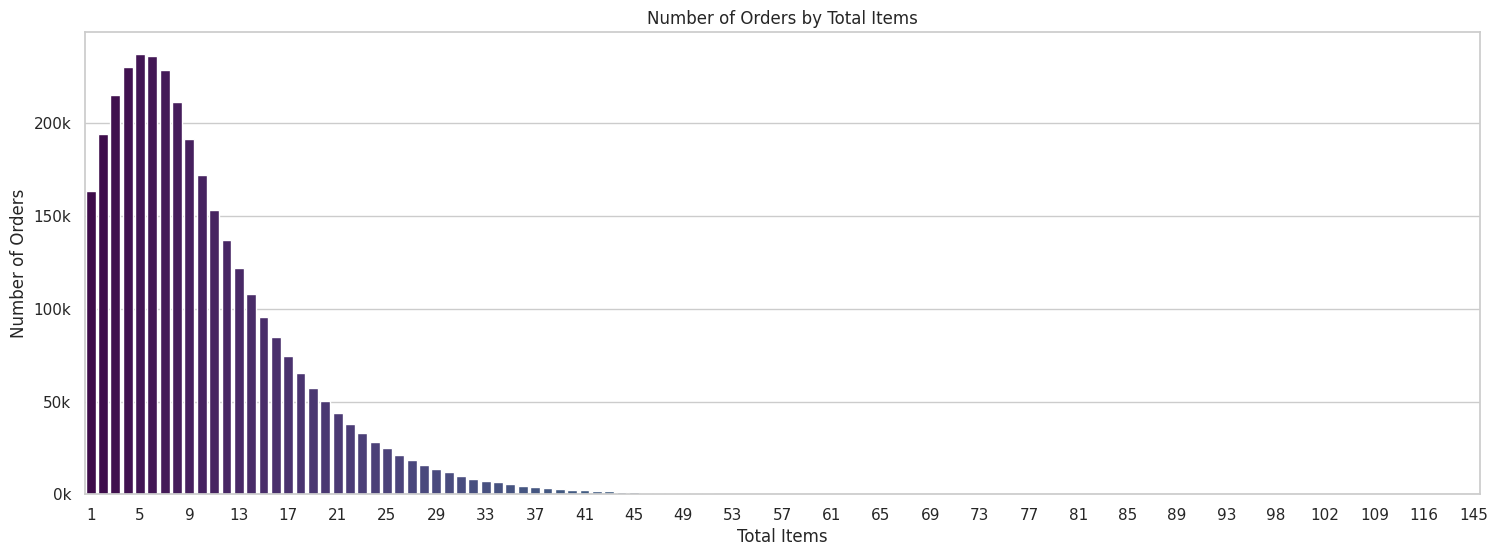

In [21]:
items_by_order_plot = items_by_order_aggregated.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(18, 6))
bar_plot = sns.barplot(x='total_items', y='num_orders', data=items_by_order_plot, 
            hue='total_items', palette='viridis', dodge=False, legend=False)

bar_plot.xaxis.set_major_locator(ticker.MultipleLocator(4))
bar_plot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))

plt.title('Number of Orders by Total Items')
plt.xlabel('Total Items')
plt.ylabel('Number of Orders')
plt.show()

### Orders by Department

Next, we will analyze which departments have the most orders.

In [22]:
query = """
SELECT department, COUNT(*) AS orders_count from order_items_temp
GROUP BY department
ORDER BY orders_count desc
LIMIT 10
"""
orders_by_department = spark.sql(query)
orders_by_department.show()

+---------------+------------+
|     department|orders_count|
+---------------+------------+
|        produce|     9888378|
|     dairy eggs|     5631067|
|         snacks|     3006412|
|      beverages|     2804175|
|         frozen|     2336858|
|         pantry|     1956819|
|         bakery|     1225181|
|   canned goods|     1114857|
|           deli|     1095540|
|dry goods pasta|      905340|
+---------------+------------+



### Visualizing Orders by Department

We will visualize the top 10 departments based on the number of orders using a pie chart.

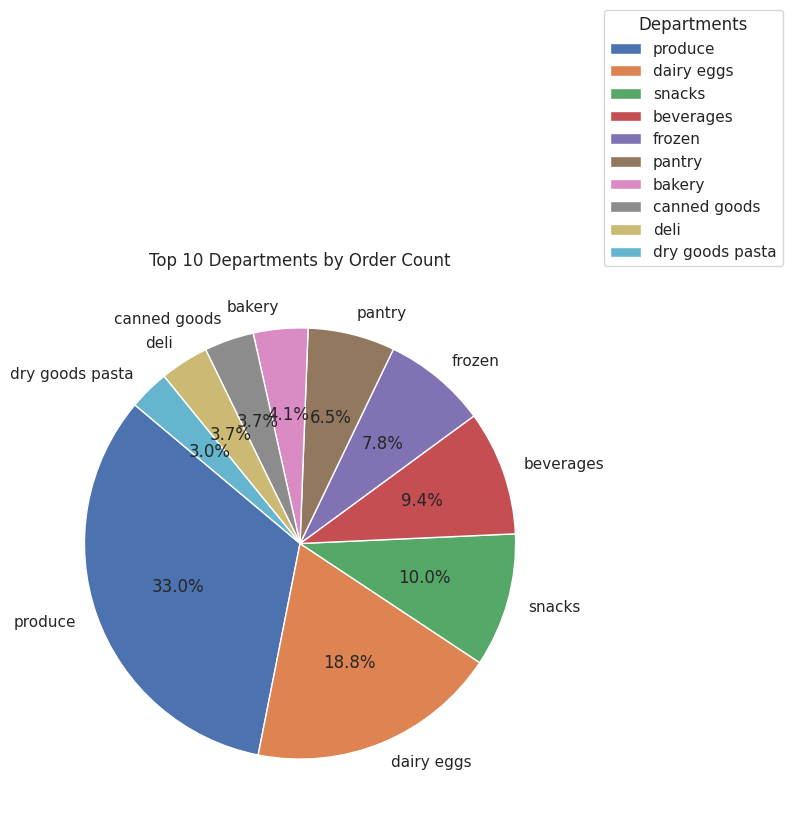

In [23]:
orders_by_department_plot = orders_by_department.toPandas()

plt.figure(figsize=(10, 7))
plt.pie(orders_by_department_plot['orders_count'], labels=orders_by_department_plot['department'],
        autopct='%1.1f%%', startangle=140)

plt.legend(orders_by_department_plot['department'], title="Departments", bbox_to_anchor=(1.05, 1), loc='best')

plt.title('Top 10 Departments by Order Count')
plt.show()

### Most Purchased Products

Let's find out which products are the most purchased by customers.

In [24]:
query = """
SELECT product_name, COUNT(*) AS orders_count from order_items_temp
GROUP BY product_name
ORDER BY orders_count desc
LIMIT 200
"""
product_by_order = spark.sql(query)
product_by_order.show(10)

+--------------------+------------+
|        product_name|orders_count|
+--------------------+------------+
|              Banana|      491291|
|Bag of Organic Ba...|      394930|
|Organic Strawberries|      275577|
|Organic Baby Spinach|      251705|
|Organic Hass Avocado|      220877|
|     Organic Avocado|      184224|
|         Large Lemon|      160792|
|        Strawberries|      149445|
|               Limes|      146660|
|  Organic Whole Milk|      142813|
+--------------------+------------+
only showing top 10 rows



In [25]:
query = """
SELECT product_name
FROM (
  SELECT product_name, count(*) AS orders_count
  FROM order_items_temp
  GROUP BY product_name
  ORDER BY orders_count DESC
  LIMIT 200
)
"""
words_df = spark.sql(query)
words = words_df.rdd.flatMap(lambda x: x).collect()
words_str = ' '.join(words)
word_cloud = WordCloud(background_color="white").generate(words_str)

### Visualizing Most Purchased Products

We will create a word cloud to visualize words related to the most frequently purchased products.

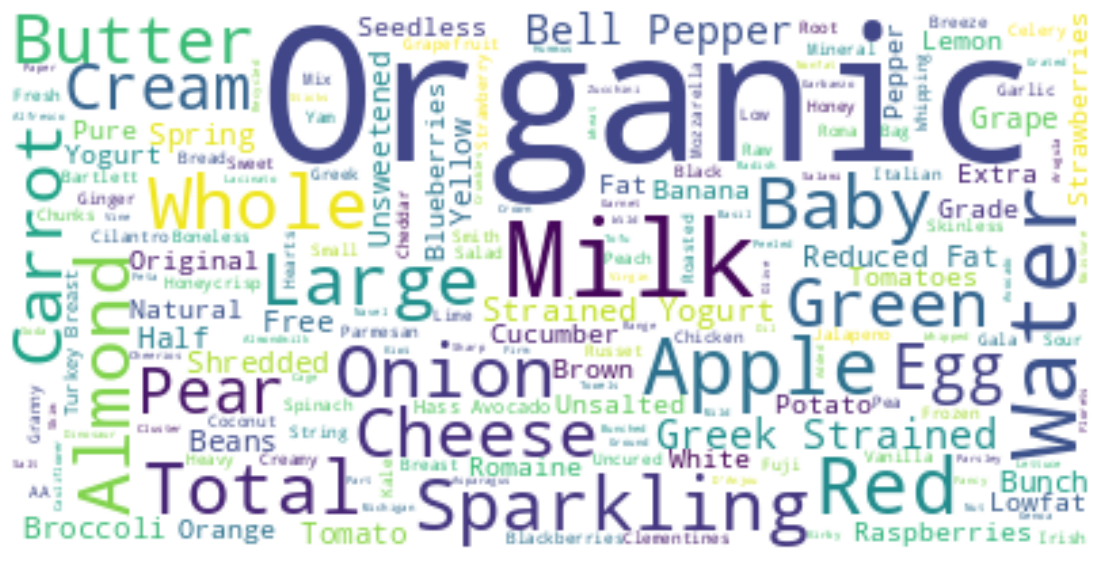

In [26]:
plt.figure(figsize=(14, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
display()

## FP-Growth Algorithm

The FP-Growth algorithm is used for frequent pattern mining.
Let's implement this algorithm to find frequent itemsets and association rules in our dataset.

### Organizing Data by Shopping Basket

First, we need to organize our data into shopping baskets.
We will create a DataFrame where each row represents a single order and contains a list of items in that order.

In [27]:
query = """
SELECT products.product_name, order_products.order_id 
FROM products 
INNER JOIN order_products_train AS order_products  
WHERE order_products.product_id = products.product_id
"""

raw_data = spark.sql(query)
raw_data.show(5, truncate=False)

+---------------------------------------------+--------+
|product_name                                 |order_id|
+---------------------------------------------+--------+
|Bulgarian Yogurt                             |1       |
|Organic 4% Milk Fat Whole Milk Cottage Cheese|1       |
|Organic Celery Hearts                        |1       |
|Cucumber Kirby                               |1       |
|Lightly Smoked Sardines in Olive Oil         |1       |
+---------------------------------------------+--------+
only showing top 5 rows



In [28]:
baskets = raw_data.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.show(5, truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|items                                                                                                                   

In [29]:
query = """
SELECT items from baskets
""" 

baskets_items = spark.sql(query).withColumn('items', expr('TRANSFORM(items, x -> CAST(x AS STRING))'))
baskets_items.show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                                                     

### Implementing FP-Growth Algorithm

Next, we will use the FP-Growth algorithm from PySpark's MLlib to find frequent itemsets and generate association rules.

In [30]:
fpgrowth = FPGrowth().setItemsCol("items").setMinSupport(0.001).setMinConfidence(0)
model = fpgrowth.fit(baskets_items)

### Frequent Itemsets

Let's take a look at the most frequent itemsets found by the FP-Growth algorithm.

In [31]:
most_popular_item_in_basket = model.freqItemsets
most_popular_item_in_basket.createOrReplaceTempView("most_popular_item_in_basket")

In [32]:
if_then = model.associationRules
if_then.createOrReplaceTempView("if_then")

In [33]:
query = """
SELECT items, freq
FROM most_popular_item_in_basket 
WHERE SIZE(items) > 2 
ORDER BY freq desc
LIMIT 20
"""

items_freq = spark.sql(query)
items_freq.show(5, truncate=False)

+--------------------------------------------------------------------+----+
|items                                                               |freq|
+--------------------------------------------------------------------+----+
|[Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas]|710 |
|[Organic Raspberries, Organic Strawberries, Bag of Organic Bananas] |649 |
|[Organic Baby Spinach, Organic Strawberries, Bag of Organic Bananas]|587 |
|[Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas] |531 |
|[Organic Hass Avocado, Organic Baby Spinach, Bag of Organic Bananas]|497 |
+--------------------------------------------------------------------+----+
only showing top 5 rows



### Association Rules

We will now examine the association rules generated by the FP-Growth algorithm, focusing on those with high confidence and lift.

### High Confidence Rules

Here are the association rules with the highest confidence values.

In [34]:
query = """
SELECT antecedent AS `antecedent (if)`, consequent AS `consequent (then)`, confidence 
FROM if_then 
ORDER BY confidence DESC
LIMIT 20
"""

confidence = spark.sql(query)
confidence.show(5, truncate=False)

+-----------------------------------------------------------------+------------------------+------------------+
|antecedent (if)                                                  |consequent (then)       |confidence        |
+-----------------------------------------------------------------+------------------------+------------------+
|[Organic Raspberries, Organic Hass Avocado, Organic Strawberries]|[Bag of Organic Bananas]|0.5984251968503937|
|[Organic Cucumber, Organic Hass Avocado, Organic Strawberries]   |[Bag of Organic Bananas]|0.546875          |
|[Organic Kiwi, Organic Hass Avocado]                             |[Bag of Organic Bananas]|0.5459770114942529|
|[Organic Navel Orange, Organic Raspberries]                      |[Bag of Organic Bananas]|0.5412186379928315|
|[Yellow Onions, Strawberries]                                    |[Banana]                |0.5357142857142857|
+-----------------------------------------------------------------+------------------------+------------

### High Lift Rules

Finally, let's look at the association rules with the highest lift values.

In [35]:
query = """
SELECT * FROM if_then 
WHERE lift > 1
ORDER BY lift DESC
"""

lift = spark.sql(query)
lift.show(5, truncate=False)

+-----------------------------------------------+-----------------------------------------------+-------------------+-----------------+--------------------+
|antecedent                                     |consequent                                     |confidence         |lift             |support             |
+-----------------------------------------------+-----------------------------------------------+-------------------+-----------------+--------------------+
|[Strawberry Rhubarb Yoghurt]                   |[Blueberry Yoghurt]                            |0.3096646942800789 |80.29801358062228|0.001196564260073623|
|[Blueberry Yoghurt]                            |[Strawberry Rhubarb Yoghurt]                   |0.3102766798418972 |80.29801358062227|0.001196564260073623|
|[Icelandic Style Skyr Blueberry Non-fat Yogurt]|[Nonfat Icelandic Style Strawberry Yogurt]     |0.2170212765957447 |78.66062066533443|0.001166078546441174|
|[Nonfat Icelandic Style Strawberry Yogurt]     |[Icelandi

## Step 12: Closing the Spark Session

Finally, we close the Spark session to release resources.

In [36]:
spark.stop()